In [1]:
import csv
import numpy as np
import pandas as pd

read input data and explore

In [2]:
df = pd.read_csv("article.csv")
print(len(df))
df = df.iloc[:, 3:5]
df.head()

82


,Insight,Insight Type
0,The Utah Jazz have helped Lauri Markkanen unlo...,"Single Player Performance, Strategy and Tactic"
1,Division and conference wins matter.,Strategy and Tactic
2,Kevin Durant had to leave the game after Jimmy...,Accident
3,"Lakers hustled more, but the Mavericks shootin...",Whole Game Review
4,"Without Kevin Durant, Kyrie Irving is aggressi...","Single Player Performance, Strategy and Tactic"


In [3]:
types = df['Insight Type'].values
types = [insight_type.split(", ") for insight_type in types]
type_dictionary = {}
for type_list in types:
    for type_ in type_list:
        # print(type_)
        if type_ not in type_dictionary:
            type_dictionary[type_] = 1
        else:
            type_dictionary[type_] += 1

type_dictionary

{'Single Player Performance': 37,
 'Strategy and Tactic': 25,
 'Accident': 14,
 'Whole Game Review': 26,
 'About Referee': 4}

<AxesSubplot:xlabel='Insight Type'>

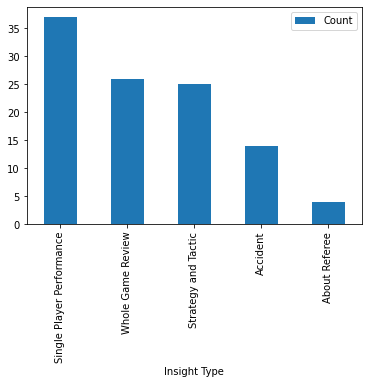

In [4]:
typeFrame = pd.DataFrame(list(type_dictionary.items()), columns=['Insight Type', 'Count']).sort_values(by='Count', axis=0, ascending=False)
typeFrame.plot(x='Insight Type', y='Count', kind='bar')

Data Preprosess

In [5]:
import re
import nltk

In [6]:
nltk.download('stopwords', './nltk')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>


False

In [8]:
nltk.data.path.append("./nltk")
stopwords_set = set(nltk.corpus.stopwords.words('english'))

replace_by_space_re = re.compile('[/(){}\[\]\|@,;]')
delete_bad_symbols_re = re.compile('[^0-9a-z #+-]')

In [9]:
def text_prepare(text):
    # text = "Hello, world!"
    text = text.lower()
    text = replace_by_space_re.sub(' ', text)
    text = delete_bad_symbols_re.sub('', text)
    text = ' '.join([word for word in text.split() if word not in stopwords_set])
    return text

In [10]:
X_train, y_train = df['Insight'].values, types

X_train = [text_prepare(x) for x in X_train]
X_train[:5]

['utah jazz helped lauri markkanen unlock offensive potential becoming kind star build new foundation around',
 'division conference wins matter',
 'kevin durant leave game jimmy butler landed knee play',
 'lakers hustled mavericks shooting prevailed helps mavericks game',
 'without kevin durant kyrie irving aggressive shot form ill-advised 30-footer']

Feature extraction

TF-IDF

TF-IDF(term frequency-inverse document frequency)是文本加权方法，采用统计思想，即文本出现的次数和整个语料中文档频率来计算字词的重要度。

优点：过滤一些常见但是无关紧要的字词。


TF（Term Frequency）表示某个关键词在整篇文章中出现的频率。（某个词在文章中出现的总次数/文章的总词数）;


IDF（Inverse Document Frequency）表示计算倒文本频率。文本频率是指某个关键词在整个语料所有文章中出现的次数。倒文档频率又称为逆文档频率，它是文档频率的倒数，主要用于降低所有文档中一些常见却对文档影响不大的词语的作用。

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

In [12]:
tf_idf = TfidfVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),token_pattern= '(\S+)')
feature = tf_idf.fit_transform(X_train)
print(feature)

  (2, 11)	0.7837532287160022
  (2, 7)	0.6210723600976314
  (3, 9)	0.9250236310005927
  (3, 7)	0.3799095709382423
  (4, 0)	1.0
  (5, 13)	1.0
  (7, 5)	1.0
  (9, 0)	1.0
  (10, 7)	1.0
  (11, 6)	0.7222887915440898
  (11, 8)	0.6915915713842805
  (12, 13)	1.0
  (13, 4)	0.5390777005627759
  (13, 3)	0.5390777005627759
  (13, 9)	0.5000679922701942
  (13, 7)	0.41075840663187557
  (14, 4)	0.5912597918624791
  (14, 3)	0.5912597918624791
  (14, 9)	0.5484739894046717
  (16, 7)	1.0
  (17, 2)	1.0
  (21, 5)	1.0
  (24, 6)	0.6284103529144639
  (24, 5)	0.6284103529144639
  (24, 7)	0.4584766697443153
  :	:
  (63, 10)	0.8078479014420621
  (63, 7)	0.589391014637699
  (64, 11)	1.0
  (66, 4)	0.5390777005627759
  (66, 3)	0.5390777005627759
  (66, 9)	0.5000679922701942
  (66, 7)	0.41075840663187557
  (67, 4)	0.5912597918624791
  (67, 3)	0.5912597918624791
  (67, 9)	0.5484739894046717
  (68, 8)	0.7208286208109487
  (68, 11)	0.6931133380766709
  (70, 10)	0.4905450898427375
  (70, 2)	0.8714158105239889
  (74, 6)	0.7

multilabel binarizer

In [13]:
from sklearn.preprocessing import MultiLabelBinarizer

In [14]:
multi_label = MultiLabelBinarizer(classes=sorted(type_dictionary.keys()))
print(y_train[0])
y_train = multi_label.fit_transform(y_train)
print(y_train[0])


['Single Player Performance', 'Strategy and Tactic']
[0 0 1 1 0]


train

In [15]:
# TF-IDF + SVM
model_tfidf_svm =  Pipeline([
    ('tfidf', TfidfVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),token_pattern= '(\S+)')),
    ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
])

In [16]:
model_tfidf_svm.fit(X_train,y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, min_df=5, ngram_range=(1, 2),
                                 token_pattern='(\\S+)')),
                ('clf', OneVsRestClassifier(estimator=LinearSVC(), n_jobs=1))])

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
 
def print_evaluation_scores(y_val, predicted):
    accuracy=accuracy_score(y_val, predicted)
    f1_score_macro=f1_score(y_val, predicted, average='macro')
    f1_score_micro=f1_score(y_val, predicted, average='micro')
    f1_score_weighted=f1_score(y_val, predicted, average='weighted')
    print("accuracy:",accuracy)
    print("f1_score_macro:",f1_score_macro)
    print("f1_score_micro:",f1_score_micro)
    print("f1_score_weighted:",f1_score_weighted)

In [18]:
predict = model_tfidf_svm.predict(X_train)
print_evaluation_scores(y_train, predict)

accuracy: 0.2682926829268293
f1_score_macro: 0.3916164669040877
f1_score_micro: 0.4836601307189543
f1_score_weighted: 0.47628818200760303


IN preposition/subordinating conjunction

JJ adjective 'big'

JJR adjective, comparative 'bigger'

JJS adjective, superlative 'biggest'

NN noun, singular 'desk'

NNS noun, plural 'desks'

NNP proper noun, singular 'Harrison'

NNPS proper noun, plural 'Americans'

VB verb, base form take